# Importing libraries and reading in file

In [1]:
# Import libraries
import pandas as pd
import nltk
from nltk import classify
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
import re

# Read in excel file
reviews = pd.read_excel('Reviews.xlsx')

# Pre processing of data

In [2]:
# Splitting out words in 'Review' column
all_words = []
for review in reviews['Review']:
    all_words.extend(review.split())

In [3]:
# Converting words from object types to strings
def convert_list_to_string(org_list, seperator=' '):
    return seperator.join(org_list)
full_str = convert_list_to_string(all_words)

In [4]:
# Tokenizing words and filtering out stop words
stop_words = set(stopwords.words('english')) 
  
word_tokens = word_tokenize(full_str) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
filtered_sentence = [] 
  
for w in word_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w) 

In [5]:
# Taking out words that are 3 characters or less

def extract_features(document):
    document_words = document.lower().split()
    document_words = [word for word in document_words if len(word) > 3]
    features = {}
    for word in all_words:
            features[f'contains({word})'] = (word in document_words)
    return features

# Training and testing model

In [6]:
# Suffling reviews to train model
reviews_shuffled = reviews.values.tolist()
random.shuffle(reviews_shuffled)

all_features = nltk.classify.apply_features(extract_features, reviews_shuffled)

In [7]:
# Training classification
training_set = all_features[:1000]
classifier = nltk.NaiveBayesClassifier.train(training_set)
classifier.show_most_informative_features()

Most Informative Features
      contains(positive) = True           Positi : Negati =     32.1 : 1.0
      contains(friendly) = True           Positi : Negati =     31.8 : 1.0
         contains(quiet) = True           Positi : Negati =     31.0 : 1.0
       contains(helpful) = True           Positi : Negati =     19.9 : 1.0
     contains(excellent) = True           Positi : Negati =     19.8 : 1.0
        contains(lovely) = True           Positi : Negati =     18.8 : 1.0
       contains(amazing) = True           Positi : Negati =     16.9 : 1.0
         contains(great) = True           Positi : Negati =     16.5 : 1.0
      contains(location) = True           Positi : Negati =     15.9 : 1.0
         contains(loved) = True           Positi : Negati =     14.6 : 1.0


In [8]:
# Testing classification and evaluating
test_set = all_features[15000:]
print("Accuracy score is: ", classify.accuracy(classifier, test_set))

Accuracy score is:  0.894314381270903


In [9]:
# Testing out classifier with example text
classifier.classify(extract_features('''Germany's coronavirus reproduction rate jumped to 2.88 yesterday, up from 1.79 a day earlier, health authorities said, a rate showing infections are rising above the level needed to contain the disease over the longer term.'''))

'Negative'

# Configuring MongoDB 

In [20]:
# Importing pymongo and extracting data previously inserted to database
import pymongo 
from pymongo import MongoClient

cluster = MongoClient("mongodb+srv://creeby:@cluster0-vilqb.azure.mongodb.net/test")

db = cluster["conorotoole_ca"]

covid_collection = db["covid"]
tbond_collection = db["tbond"]
amzn_collection = db["amazon"]
oil_collection = db["oil"]
article_collection = db["articles"]

# Classifying articles and inserting them into MongoDB
reviews = pd.read_excel('Articles.xlsx')
for index, row in reviews.iterrows():
    sentiment = classifier.classify(extract_features(row['text']))
    mydict = {'url': row['url'], 'publication_date': row['date'], 'sentiment': sentiment}
    insert = article_collection.insert_one(mydict)
    print(insert)

In [11]:
# Converting data to pandas dataframes
covid = pd.DataFrame(list(covid_collection.find()))
tbond = pd.DataFrame(list(tbond_collection.find()))
amzn = pd.DataFrame(list(amzn_collection.find()))
oil = pd.DataFrame(list(oil_collection.find()))
article = pd.DataFrame(list(article_collection.find()))

In [12]:
# Splitting positive/negative articles and summing them for analysis
split = article['sentiment'].value_counts()
print(split)

Negative    160
Positive     30
Name: sentiment, dtype: int64


In [13]:
# Merging dataframes to consolidate dates
df2 = pd.merge(left=covid, left_on='date', right=tbond, right_on='Date')
df3 = pd.merge(left=df2, left_on='date', right=amzn, right_on='Date')
df4 = pd.merge(left=df3, left_on='date', right=oil, right_on='Date')
df4.head(5)

,_id_x,level_0,index_x,date,location,new_cases,_id_y,index_y,Date_x,Close_x,_id_x,index_x,Date_y,Close_y,_id_y,index_y,Date,Close
0,5ee127fd31c0e41a21be514e,2,203,2020-01-02,World,0,5ee1281731c0e41a21be51ef,0,2020-01-02,1.882,5ee1281b31c0e41a21be526d,0,2020-01-02,1898.010010,5ee1281b31c0e41a21be52d4,0,2020-01-02,61.180000
1,5ee127fd31c0e41a21be514f,3,271,2020-01-03,World,17,5ee1281731c0e41a21be51f0,1,2020-01-03,1.788,5ee1281b31c0e41a21be526e,1,2020-01-03,1874.969971,5ee1281b31c0e41a21be52d5,1,2020-01-03,63.049999
2,5ee127fd31c0e41a21be5152,6,475,2020-01-06,World,0,5ee1281731c0e41a21be51f2,3,2020-01-06,1.811,5ee1281b31c0e41a21be526f,2,2020-01-06,1902.880005,5ee1281b31c0e41a21be52d7,3,2020-01-06,63.270000
3,5ee127fd31c0e41a21be5153,7,543,2020-01-07,World,0,5ee1281731c0e41a21be51f3,4,2020-01-07,1.827,5ee1281b31c0e41a21be5270,3,2020-01-07,1906.859985,5ee1281b31c0e41a21be52d8,4,2020-01-07,62.700001
4,5ee127fd31c0e41a21be5154,8,611,2020-01-08,World,0,5ee1281731c0e41a21be51f4,5,2020-01-08,1.874,5ee1281b31c0e41a21be5271,4,2020-01-08,1891.969971,5ee1281b31c0e41a21be52d9,5,2020-01-08,59.610001


In [14]:
# Extracting values needed from merged dataframe
covid_cases = df4[['new_cases']]
tbond_close = df4[['Close_x']]
amzn_close = df4[['Close_y']]
oil_close = df4[['Close']]

In [15]:
# Scaling/normalizig data so it is comparable
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

covid_cases = scaler.fit_transform(covid_cases)
tbond_close = scaler.fit_transform(tbond_close)
amzn_close = scaler.fit_transform(amzn_close)
oil_close = scaler.fit_transform(oil_close)

# Visualising data

C:\Users\Conor\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


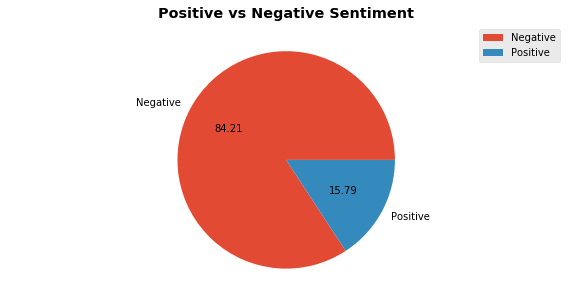

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

# Percentage split of positive and negative articles from data as classified by model
plt.figure(figsize=(10,5))
plt.axis('equal')
plt.pie([split], labels = ['Negative', 'Positive'], autopct='%.2f')
plt.title('Positive vs Negative Sentiment', fontweight='bold')
plt.legend()
plt.show()

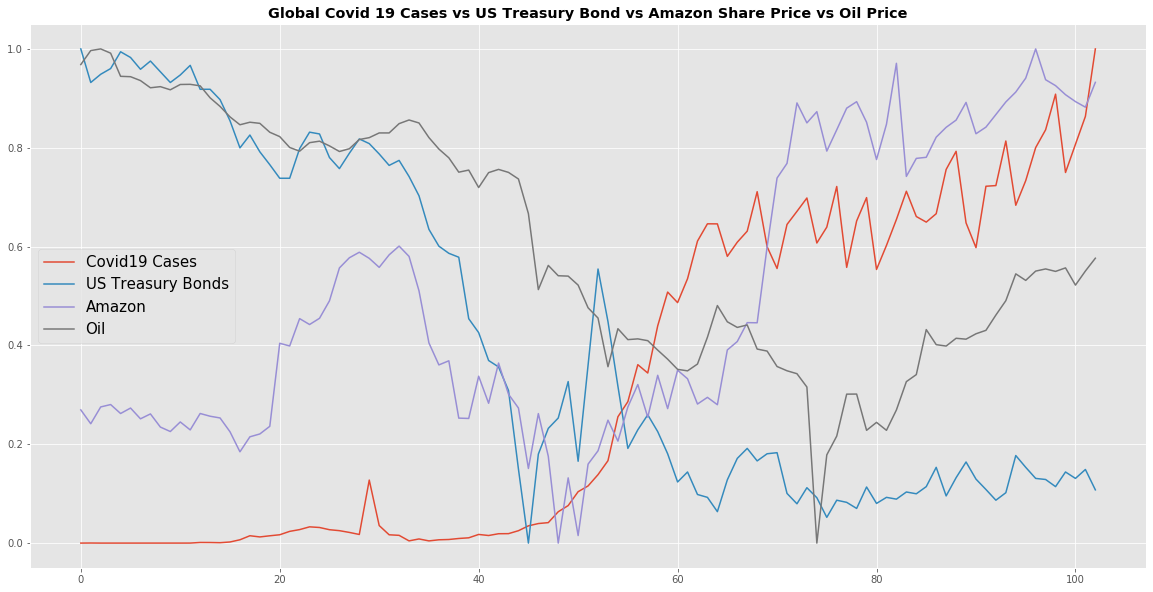

In [17]:
# Plotting data on line graph so we can compare them visually

plt.figure(figsize=(20,10))

plt.plot(covid_cases, label = "Covid19 Cases") 
plt.plot(tbond_close, label = "US Treasury Bonds")
plt.plot(amzn_close, label = "Amazon")
plt.plot(oil_close, label = "Oil")

plt.title('Global Covid 19 Cases vs US Treasury Bond vs Amazon Share Price vs Oil Price', fontweight='bold') 

plt.legend(prop={'size': 15}) 
 
plt.show()

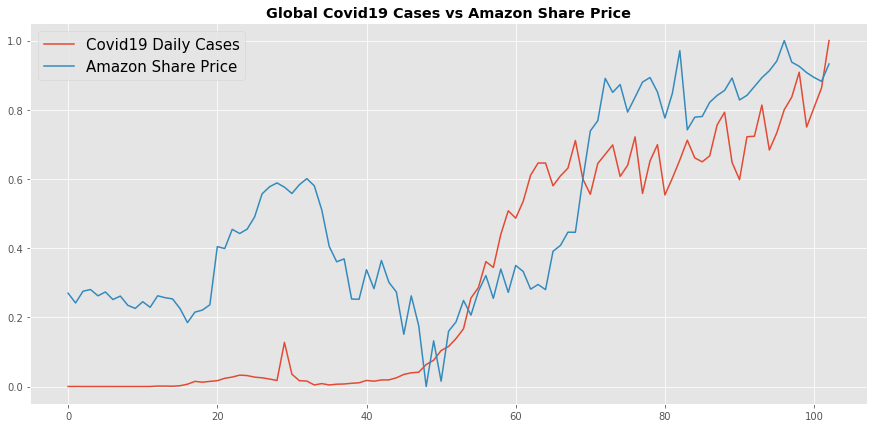

In [18]:
plt.figure(figsize=(15,7))

plt.plot(covid_cases, label = "Covid19 Daily Cases") 
plt.plot(amzn_close, label = "Amazon Share Price")

plt.title('Global Covid19 Cases vs Amazon Share Price', fontweight='bold') 

plt.legend(prop={'size': 15}) 

plt.show() 

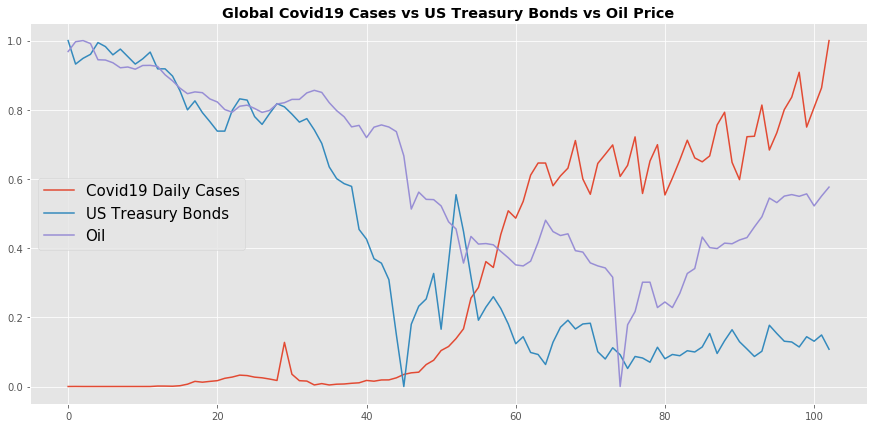

In [19]:
plt.figure(figsize=(15,7))

plt.plot(covid_cases, label = "Covid19 Daily Cases") 
plt.plot(tbond_close, label = "US Treasury Bonds")
plt.plot(oil_close, label = "Oil")

plt.title('Global Covid19 Cases vs US Treasury Bonds vs Oil Price', fontweight='bold') 

plt.legend(prop={'size': 15}) 

plt.show() 

As there was a lot of data available with publicly traded assets, I chose to use 3 different financial assets across 3 different industries/sectors. Firstly, Amazon was interesting as it has done very well since the outbreak and I was interested in investigating into this further. The increase in the share price would be because of the rise in demand in online shopping seeing as people could not go to the shop and buy things and so websites like Amazon benefitted from this and the share price increased accordingly.

Secondly, US Treasury bonds, which generally reflect the sentiment of the US government itself, I was intrigued to see the reaction of this from the virus. A decline as corona cases increased followed by a short spike before the real outbreak happened. It seems as though that these government bonds along with most assets are recovering.

Finally, oil price as a volatile commodity, this has been extremely unpredictable and thought it was worth looking at further. Like bonds, a steady decline is seen as the number of cases increased, it seems as though the corona virus really affected the price. This would be down to a number of factors, including, people/companies not using as much of the transportation and infrastructure majorly cut down. There was a big impact on the price but like other assets it seems to be recovering.

The pre processing of data was difficult as I found with this type of assignment, if this was not done right then the rest of the project would suffer. Things like removing stop words and converting data type to string. Pre processing before visualisation also took a bit of work. Not only the configuration with MongoDB and inserting/fetching the data but I quickly found out that because the markets for some publicly traded instruments are closed on weekends it was coming up as a NaN value and therefore leaving gaps and inconsistencies in line graphs and of course, as corona virus does not close on weekends I had to match up the dates between each of the assets and virus data. This also helped as I had more dates for the corona virus data and so that line would run further off the graph than the rest of the lines. 